In [193]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
from cStringIO import StringIO

import numpy as np
import requests

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
for module in ['hosts', 'targeting', 'mmthecto']:
    if module in globals():
        reload(globals()[module])
    else:
        globals()[module] = __import__(module)
g = targeting.get_gama() #re-caches the gama catalo

In [186]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [45]:
from astropy import units as u

from astropy.table import Table
from astropy import table
from astropy.coordinates import SkyCoord

In [5]:
# this version includes those both with *and* without incomplete data
mltab = Table.read('catalogs/SAGA.objid.noclean.PROBS_WISE_PROBS.sept28.fits.gz')
mltab

OBJID_1,RA,DEC,DERED_R,PROBABILITY_CLASS_1,BEST_GUESS_CLASS,OBJID_2,PROBABILITY_CLASS_WISE_1,BEST_GUESS_CLASS_WISE
int64,float64,float64,float64,float64,int64,int64,float64,int64
1237645941824356440,40.2877964113,-0.735647060949,16.7594,0.00157168316197,0,1237645941824356440,0.00237542184974,0
1237645941824356442,40.2745834514,-0.733014063478,17.4514,0.000372493836691,0,1237645941824356442,0.000150014828525,0
1237645941824356481,40.2721052363,-0.642510253204,16.7911,0.00178514575454,0,1237645941824356481,0.00118868512323,0
1237645941824356483,40.2712777717,-0.640725293001,20.9894,0.000240454811286,0,--,nan,--
1237645941824356497,40.2846730128,-0.817180215799,14.8628,0.000363130559728,0,1237645941824356497,0.000762738659167,0
1237645941824356500,40.2881452154,-0.805045508948,14.3826,0.000488674982738,0,1237645941824356500,0.000541563342248,0
1237645941824356501,40.2854134086,-0.804100473432,20.2454,0.000763301466982,0,--,nan,--
1237645941824356546,40.2730041845,-0.652374482075,17.2435,0.000137542029002,0,1237645941824356546,9.49131806038e-05,0
1237645941824356597,40.287315948,-0.767897839046,19.8969,0.000115278704656,0,1237645941824356597,4.28634811895e-05,0


In [6]:
allspec = Table.read(os.environ['HOME']+'/Dropbox/SAGA/data/allspectaken_v4.fits')
allsats = allspec[(allspec['SATS']==1)&(allspec['REMOVE']==-1)]
allsats

objID,ra,dec,phot_sg,flags,specObjID,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,Au,Ag,Ar,Ai,Az,fibermag_r,fiber2mag_r,expRad_r,sb_exp_r,petroR50_r,petroR90_r,petroMag_r,sb_petro_r,J,Jerr,H,Herr,K,Kerr,w1,w1err,w2,w2err,spec_z,spec_z_err,spec_z_warn,photoz,photoz_err,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,PCLASS_1,SATS,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_REPEAT
int64,float64,float64,int16,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,int64,int64,string384,float64,float64,int64,int64,int64,int64,string32,string384,float64,string384
1237648702984683605,225.005401226,-1.09130226734,3,1161121054724696,1038170464519743488,16.0251,15.3274,15.0087,14.9003,14.7838,0.00790307,0.00274512,0.00320407,0.00445661,0.00904204,0.327712,0.241128,0.174886,0.132611,0.0940226,17.9322,18.7455,-99.0,-99.0,6.35402,15.5154,-99.0,20.980901535,16.079,0.2,14.286,9999.0,14.022,9999.0,12.5717,0.00404706,13.452,0.031,0.00629765,5.12096e-06,0,0.052463,0.042043,224.594,-1.09102,28.4038,1922.0,7.693,145729,0,,24.6830184051,203.937503578,35574,-1,1,-1,NSA,sdss,4.0,SDSS
1237650372092690464,180.29544216,-1.2976838319,3,1319448581640280,0,14.7189,13.8689,13.5233,13.3643,13.3112,0.00616112,0.00218275,0.00221878,0.00297785,0.00571236,0.18759,0.138027,0.100109,0.0759093,0.0538207,18.1215,18.8384,-99.0,-99.0,16.2607,36.7104,-99.0,21.3926642507,16.481,0.203,14.687,9999.0,14.353,9999.0,13.57,0.032,13.415,0.042,0.00496344,-1.0,0,0.03922,0.037245,180.098,-1.10008,23.2487,1465.0,7.321,140594,0,Alice,16.7329983482,113.161017531,171514,-1,1,-1,NSA,sixdf,4.0,
1237662524159557759,195.103918476,13.6702528117,3,263951778713872,1993991333693384704,16.2941,15.3909,15.0711,14.9532,14.9347,0.0227312,0.00667544,0.0117505,0.0181898,0.0299357,0.182322,0.134151,0.0972974,0.0737777,0.0523093,19.5029,20.3731,-99.0,-99.0,11.7887,31.5461,-99.0,22.1488131629,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,14.931,0.04,14.662,0.071,0.00670154,1.43393e-05,0,0.02964,0.021994,194.863,14.1712,30.027,1988.0,7.907,142722,0,,33.1822246225,289.825648558,75784,-1,1,-1,NSA,sdss,4.0,SDSS
1237662525233037420,194.572104136,14.5571518823,3,1161189774200920,1994022669774776320,15.0794,13.9057,13.3422,13.0646,12.8458,0.00876489,0.00258233,0.00253072,0.00278083,0.00790994,0.138485,0.101896,0.0739036,0.0560389,0.0397323,18.0356,18.8593,-99.0,-99.0,22.4107,63.5675,-99.0,21.8393358194,15.688,0.138,15.075,0.166,14.543,0.125,10.978,0.00166256,13.465,0.062,0.00674294,1.85704e-05,0,0.044988,0.01468,194.863,14.1712,30.027,1988.0,7.907,142722,0,,28.678557215,250.4899595,169964,-1,1,-1,NSA,sdss,4.0,SDSS
1237662196143947955,206.062030556,41.6773969113,3,35253360136464,1550476098200954880,17.5703,16.3626,15.7229,15.4422,15.4075,0.0357736,0.00551178,0.00491173,0.0056155,0.0156972,0.0372117,0.02738,0.0198583,0.0150579,0.0106763,18.7425,19.4958,-99.0,-99.0,6.86541,23.2344,-99.0,21.817637634,16.626,0.129,15.818,0.131,15.683,0.189,13.8742,0.00752922,14.749,0.05,0.00869595,9.33515e-06,0,0.055504,0.026538,206.33,41.7125,37.2285,2549.01,8.434,163956,0,,12.1863238779,131.9694668,56424,-1,1,-1,NSA,sdss,4.0,SDSS
1237662307796910232,206.19066673,41.5567177,3,475058011246640,1550486543561418752,18.255,17.0938,16.5442,16.2924,16.1036,0.0368874,0.00637697,0.00590459,0.00811227,0.0274015,0.0439143,0.0323118,0.0234352,0.0177702,0.0125993,19.298,20.0954,-99.0,-99.0,5.57039,13.9169,-99.0,22.19578327,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,14.2203,0.010956,15.078,0.061,0.00894533,2.04436e-05,0,0.048505,0.029693,206.33,41.7125,37.2285,2549.01,8.434,163956,0,,11.2416329592,121.739154933,56427,-1,1,-1,NSA,sdss,4.0,SDSS
1237662300829384713,228.771613868,42.2094568926,3,1178711

In [7]:
# info on all the hosts to decide which to investigate further
nsaid2name = {}
for row in allsats:
    nsaid2name[row['HOST_NSAID']] = row['HOST_SAGA_NAME']
    
Table(rows=[(i, 
         nsaid2name[i], 
         np.sum(allsats['HOST_NSAID']==i), 
         np.sum((allsats['HOST_NSAID']==i)&(allsats['MASKNAME']!='sdss')))
        for i in np.unique(allsats['HOST_NSAID'])],
      names=['NSAID', 'host name', 'n_sats', 'n_sats_not_sdss']).pprint(max_lines=1000)

NSAID  host name n_sats n_sats_not_sdss
------ --------- ------ ---------------
    32                1               0
 16235                3               0
 16559                2               0
 33446  StarTrek      2               0
 61945      AnaK      2               0
 69028                3               1
 85746  MobyDick      1               1
 94217                1               0
135129                5               0
135440                1               0
135667   Beowulf      8               4
135739                3               1
135879                5               2
137625                3               0
138201                5               0
138375                3               1
138642                2               0
139281                4               0
140065                3               1
140301                2               1
140458                1               0
140594     Alice      1               1
141465                1               0


# Odyssey it is, then...

In [26]:
ody = hosts.odyssey

In [12]:
odycat = Table.read('catalogs/base_sql_nsa147100.fits.gz')
odycat

objID,ra,dec,phot_sg,flags,specObjID,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,Au,Ag,Ar,Ai,Az,fibermag_r,fiber2mag_r,expRad_r,sb_exp_r,petroR50_r,petroR90_r,petroMag_r,sb_petro_r,J,Jerr,H,Herr,K,Kerr,w1,w1err,w2,w2err,spec_z,spec_z_err,spec_z_warn,photoz,photoz_err,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_REPEAT
int64,float64,float64,int16,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,int64,int64,string376,float64,float64,int64,int64,int64,string32,string376,float64,string376
1237662698115433791,248.118777512,19.8004829221,3,422281453109248,0,24.7068,24.2954,22.8391,21.9429,21.7009,0.697723,0.392243,0.170579,0.121857,0.294142,0.320407,0.235753,0.170987,0.129655,0.0919267,23.2992,23.6464,0.294044,22.176847514,0.455496,0.703098,23.2479,23.5357802098,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,19.0787,0.567587,9999.0,9999.0,-1.0,-1.0,-1,0.548446,0.069731,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,2.37386224364,23.698868408,-1,-1,-1,,,-1.0,
1237662698115433225,248.122956558,19.84698244,3,68987912704,0,23.0513,22.3732,21.5723,21.3998,20.9263,0.365024,0.0997711,0.0672925,0.089948,0.189554,0.32472,0.238926,0.173289,0.1314,0.0931641,21.9666,22.4928,0.440515,21.7874616383,0.664405,1.39084,21.6313,22.738949526,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,19.6234,0.94774,9999.0,9999.0,-1.0,-1.0,-1,0.321552,0.039179,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,2.37571378548,23.7173528165,-1,-1,-1,,,-1.0,
1237662698115433190,248.069496538,19.7887422658,3,35253360132880,0,24.5675,25.0638,22.7863,21.6097,20.434,0.820711,0.586361,0.195418,0.108085,0.126804,0.319335,0.234964,0.170415,0.129221,0.0916191,23.0323,23.5422,0.429894,23.0694281912,0.552322,1.63742,22.9837,23.6901396425,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,18.0141,0.209077,9999.0,9999.0,-1.0,-1.0,-1,0.794459,0.103854,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,2.46601607024,24.6188632595,-1,-1,-1,,,-1.0,
1237662698115433217,248.076445205,19.7864371366,3,68987912960,0,19.4174,19.2179,17.1682,16.926,16.2733,0.573969,0.214328,0.0490137,0.0635936,0.115549,0.318934,0.234669,0.170201,0.129058,0.091504,22.6345,23.2129,59.3508,28.0308163196,75.3133,130.953,16.0952,27.475053011,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,19.4031,0.76088,9999.0,9999.0,-1.0,-1.0,-1,0.390898,0.113254,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,2.47067336836,24.6653582387,-1,-1,-1,,,-1.0,
1237662698115433272,248.130562637,19.8317867144,6,35253393686800,0,24.9046,23.6089,21.9025,21.427,21.1317,0.604975,0.226984,0.071794,0.0728801,0.176577,0.323539,0.238057,0.172658,0.130922,0.0928251,22.2718,22.7378,0.000677626,8.05295622409,0.398754,0.8149,22.1628,22.1618254998,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,18.0641,0.23212,9999.0,9999.0,-1.0,-1.0,-1,-1.0,-1.0,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,2.47997751065,24.7582438325,-1,-1,-1,,,-1.0,
1237662698115433729,248.065855461,19.7910845264,3,281640601387776,0,19.8928,20.2202,18.527,18.1614,17.3495,0.422043,0.264267,0.0810354,0.0943239,0.147665,0.319458,0.235054,0.170481,0.12927,0.0916543,22.9048,23.4504,0.624583,23.4314631994,0.660898,1.92294,22.4559,23.5520558939,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,17.8853,0.185322,9999.0,9999.0,-1.0,-1.0,-1,0.49716,0.124777,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,2.43191926069,24.2784662276,-1,-1,-1,,,-1.0,
1237662698115433063,248.111859856,19.7906770758,6,281543964623104,0,22.6225,25.1353,24.0488,23.0493,22.7698,0.218083,0.454496,0.365421,0.266557,0.406368,0.318928,0.234664,0.170198,0.129056,0.0915024,23.9939,24.3292,59.3401,27.8721827777,0.615847,1.38758

In [15]:
odysats = allsats[allsats['HOST_NSAID']==147100]
odysats

objID,ra,dec,phot_sg,flags,specObjID,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,Au,Ag,Ar,Ai,Az,fibermag_r,fiber2mag_r,expRad_r,sb_exp_r,petroR50_r,petroR90_r,petroMag_r,sb_petro_r,J,Jerr,H,Herr,K,Kerr,w1,w1err,w2,w2err,spec_z,spec_z_err,spec_z_warn,photoz,photoz_err,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,PCLASS_1,SATS,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_REPEAT
int64,float64,float64,int16,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,int64,int64,string384,float64,float64,int64,int64,int64,int64,string32,string384,float64,string384
1237662662147571761,248.393225697,19.9461400824,3,35221147877392,1867934519995164672,17.2353,16.2897,15.8196,15.6593,15.461,0.0138057,0.00351746,0.0032581,0.00380921,0.00915628,0.337488,0.248321,0.180103,0.136566,0.0968273,17.5609,18.279,-99.0,-99.0,3.01374,8.61439,-99.0,20.1488039442,15.698,0.128,15.075,0.153,14.752,0.119,13.0743,0.00368057,13.355,0.033,0.00804823,5.23156e-06,0,0.023084,0.01586,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,18.7177808521,186.863441632,68553,-1,1,-1,NSA,sdss,4.0,SDSS
1237662224092364842,247.877387573,20.0936248407,3,105622104314128,2087589736049829888,18.4211,17.4923,17.175,16.9614,17.2141,0.0612094,0.0123969,0.0146603,0.0203313,0.0885459,0.334959,0.246459,0.178753,0.135543,0.0961016,20.931,21.6809,15.9824,25.1886963988,8.25063,15.0494,17.3796,23.9575303748,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,15.4225,0.0690004,16.388,0.256,0.00826426,6.53467e-06,0,0.079961,0.09424,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,19.926148232,198.926689786,-1,-1,1,-1,SDSS,SDSS,4.0,SDSS
1237662698115432783,248.152079686,19.8102591366,3,35255507620112,277,19.0546,18.1465,17.7914,17.4775,17.4055,0.0773064,0.0153358,0.0324549,0.0447302,0.0495881,0.321538,0.236585,0.171591,0.130112,0.0922513,20.6449,21.4225,8.2159,24.3601194323,5.00132,9.54644,17.9565,23.4474214826,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,15.6168,0.047804,16.843,9999.0,0.007628,-1.0,-1,0.090768,0.024933,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,3.79884263751,37.9248041215,-1,-1,1,-1,MMT,/Spectra/Final/MMT/spHect-2014.0524_2.zlog,4.0,
1237662698115432544,248.051339587,19.6957396993,3,35253360136208,251,18.39,17.2268,16.7923,16.5862,16.4482,0.0361621,0.00689268,0.00642301,0.00810959,0.0214018,0.282299,0.207713,0.150651,0.114234,0.0809933,19.5035,20.2686,7.52481,23.1702759032,5.16195,12.366,16.8133,22.3727912602,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,14.5022,0.0166047,15.556,0.137,0.008224,-1.0,-1,0.021226,0.008567,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,8.09388445004,80.8032315415,-1,-1,1,-1,MMT,/Spectra/Final/MMT/spHect-2013.0510_5.zlog,4.0,
1237662224092496776,248.195368592,19.8670126788,3,281692140995328,194,20.1782,19.039,18.7417,18.5248,18.5186,0.113563,0.0297564,0.0592249,0.104794,0.109641,0.342584,0.25207,0.182822,0.138629,0.0982894,20.7875,21.604,3.51102,23.4642938115,3.09963,5.80399,18.7214,23.1734135002,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,16.4174,0.0680637,17.08,9999.0,0.00824,-1.0,-1,0.041919,0.019328,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,6.58420997559,65.7318019202,-1,-1,1,-1,MMT,/Spectra/Final/MMT/spHect-2014.0524_1.zlog,3.0,
1237662698115433445,248.16342684,19.792207594,3,68988043520,300,21.9272,20.7542,20.4952,21.0372,20.1334,0.337207,0.0595209,0.0632088,0.172284,0.226826,0.319494,0.23508,0.1705,0.129285,0.0916646,21.7503,22.3825,1.20396,23.3425458071,1.38253,4.08204,20.8234,23.5222017793,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,20.3685,1.83637,9999.0,9999.0,0.007471,-1.0,-1,0.039585,0.044217,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,4.77678492407,47.6878429659,

## Are the objID-matches complete?

In [20]:
np.all(np.in1d(odysats['objID'], mltab['OBJID_1']))

True

OK, all sats are represented, at least

In [22]:
np.sum(np.in1d(odycat['objID'], mltab['OBJID_1'])), np.sum(np.in1d(odycat['objID'], mltab['OBJID_2'])), len(odycat)

(34354, 20972, 116533)

In [25]:
np.sum(np.in1d(mltab['OBJID_1'], odycat['objID'])), np.sum(np.in1d(mltab['OBJID_2'], odycat['objID']))

(34337, 20955)

In [36]:
mlclosemsk = SkyCoord(mltab['RA'], mltab['DEC'], unit=u.deg).separation(ody.coords) < 2*u.deg
np.sum(np.in1d(mltab[mlclosemsk]['OBJID_1'], odycat['objID'])), np.sum(np.in1d(mltab[mlclosemsk]['OBJID_2'], odycat['objID'])), np.sum(mlclosemsk)

(34337, 20955, 52841)

Lets just forge ahead assuming OBJID_1 is the thing to match against

In [52]:
mltab['objID'] = mltab['OBJID_1']
joinedcat = table.join(odycat, mltab)
joinedsats = table.join(odysats, mltab)
del mltab['objID']
joinedcat

objID,ra,dec,phot_sg,flags,specObjID,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,Au,Ag,Ar,Ai,Az,fibermag_r,fiber2mag_r,expRad_r,sb_exp_r,petroR50_r,petroR90_r,petroMag_r,sb_petro_r,J,Jerr,H,Herr,K,Kerr,w1,w1err,w2,w2err,spec_z,spec_z_err,spec_z_warn,photoz,photoz_err,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_REPEAT,OBJID_1,RA,DEC,DERED_R,PROBABILITY_CLASS_1,BEST_GUESS_CLASS,OBJID_2,PROBABILITY_CLASS_WISE_1,BEST_GUESS_CLASS_WISE
int64,float64,float64,int16,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,int64,int64,string376,float64,float64,int64,int64,int64,string32,string376,float64,string376,int64,float64,float64,float64,float64,int64,int64,float64,int64
1237662223555166384,247.11293002,20.1256853311,6,35253361705492,0,18.1957,16.947,16.4771,16.3074,16.2429,0.0124589,0.00499027,0.00530594,0.00540558,0.00749857,0.333814,0.245617,0.178142,0.13508,0.0957733,16.7965,17.2826,0.0,-33.5228881836,0.482507,1.06325,16.5441,16.957086064,15.395,0.047,14.952,0.056,14.933,0.105,14.7899,0.0121057,15.065,0.094,-1.0,-1.0,-1,-1.0,-1.0,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,57.8381103188,577.38531951,-1,-1,-1,,,-1.0,,1237662223555166384,247.11293002,20.1256853311,16.299,0.000229049863275,0,1237662223555166384,0.000321836795232,0
1237662223555166389,247.099255456,20.1193947989,6,105553419960340,0,22.3818,22.3291,20.0641,21.8965,20.4567,0.221007,0.112194,0.0237527,0.151511,0.138532,0.334615,0.246206,0.178569,0.135404,0.0960029,18.6334,19.3733,0.181013,18.3480508817,0.475495,0.938425,20.2014,20.582538017,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,-1.0,-1.0,-1,-1.0,-1.0,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,58.4576886899,583.56984309,-1,-1,-1,,,-1.0,,1237662223555166389,247.099255456,20.1193947989,19.8855,0.0667863505689,0,--,nan,--
1237662223555166535,247.071365106,20.0635458809,6,35255507619856,2087459993677752320,17.8029,17.4107,17.4107,17.2458,17.3649,0.0102857,0.00540287,0.0059601,0.0062408,0.0126736,0.34348,0.252729,0.1833,0.138991,0.0985464,17.7286,18.2165,0.0172994,10.5964694955,0.498376,1.10493,17.4688,17.9519996728,16.254,0.088,15.647,0.102,15.002,0.118,13.219,0.0026685,12.046,0.025,0.570136,5.64646e-05,0,-1.0,-1.0,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,59.0654167929,589.636060941,-1,-1,-1,SDSS,SDSS,4.0,SDSS,1237662223555166535,247.071365106,20.0635458809,17.2274,0.000457855631498,0,1237662223555166535,0.000146487512574,0
1237662223555166681,247.117228848,20.1392443591,6,34628174336,0,22.0497,20.3061,19.1708,17.9802,17.2691,0.146515,0.0194609,0.011475,0.00800152,0.0124577,0.333683,0.24552,0.178072,0.135027,0.0957355,19.5244,20.0344,0.318544,18.6821409147,0.554991,1.24055,19.2179,19.9347758823,15.775,0.068,15.243,0.076,14.873,0.102,14.8621,0.0125711,14.812,0.077,-1.0,-1.0,-1,-1.0,-1.0,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,57.8662658986,577.666364021,-1,-1,-1,,,-1.0,,1237662223555166681,247.117228848,20.1392443591,18.9928,0.00011964491182,0,1237662223555166681,5.27159388403e-05,0
1237662223555166763,247.079130398,20.1190341086,3,68987912704,0,21.4626,19.1799,18.1204,17.6416,17.323,0.214576,0.0167249,0.0101003,0.0100395,0.0251367,0.33632,0.247461,0.179479,0.136094,0.0964921,19.3776,20.0229,1.46004,21.2780427918,1.68581,4.44688,18.2911,21.4206465065,16.756,0.137,16.027,0.139,15.614,0.201,14.6923,0.0149673,14.88,0.081,-1.0,-1.0,-1,0.129631,0.023243,248.087,19.8264,34.3199,2375.0,8.65,147100,0,Odyssey,59.5356297471,594.329618018,-1,-1,-1,,,-1.0,,1237662223555166763,247.079130398,20.1190341086,17.9409,0.00053454982081,0,1237662223555166763,0.00031104163

In [135]:
def find_similar_objects(baseobj, catalog, propertytolerances):
    """
    minus sign on propertytolerances means *multiplicative* tolerance (>1).  Can also
    be a function that takes the base value and comparison val and gives a mask
    """
    msk = np.ones(len(catalog), dtype=bool)
    
    for prop, tol in propertytolerances.items():
        if '-' in prop:
            m1, m2 = prop.split('-')
            compval = catalog[m1] - catalog[m2]
            baseval = baseobj[m1] - baseobj[m2]
        else:
            compval = catalog[prop]
            baseval = baseobj[prop]
            
        if callable(tol):
            msk = msk & tol(baseval, compval)
        elif tol >=0:
            msk = msk & (np.abs(compval - baseval) < tol)
        else:
            msk = msk & ((baseval/-tol)<compval) & (compval<(baseval*-tol))
    
    return catalog[msk]

def show_similar_objects(baseobj, catalog, propertytolerances, nameinfo=None):
    simcat = find_similar_objects(baseobj, catalog, propertytolerances)
    ras = np.insert(simcat['ra'], 0, baseobj['ra'])
    decs = np.insert(simcat['dec'], 0, baseobj['dec'])
    if nameinfo is None:
        names = ['Fakeobj{}'.format(i) for i in range(len(simcat))]
        names.insert(0, 'Realobj')
    else:
        nameinfolabel = 'p' if nameinfo.startswith('PROBABILITY') else nameinfo
        names = ['Fakeobj{}_{}={:.3f}'.format(i, nameinfolabel, row[nameinfo]) for i, row in enumerate(simcat)]
        names.insert(0, 'Realobj_{}={:.3f}'.format(nameinfolabel, baseobj[nameinfo]))

    targeting.sampled_imagelist(ras, decs, names=names, n=np.inf, posttoimglist=0.5)
    return simcat

In [136]:
proptols = {'r':.2, 'g-r':.2, 'petroR50_r':-3}

In [144]:
highprobtols = proptols.copy()
highprobtols['PROBABILITY_CLASS_1'] = lambda objval, catval: catval> (objval*.75)

highprobcats = []
for sat in joinedsats:
    highprobcats.append(show_similar_objects(sat, joinedcat, highprobtols, 'PROBABILITY_CLASS_1'))

In [145]:
lowprobtols = proptols.copy()
lowprobtols['PROBABILITY_CLASS_1'] = lambda objval, catval: catval <  (objval*.5)

lowprobcats = []
for sat in joinedsats:
    lowprobcats.append(show_similar_objects(sat, joinedcat, lowprobtols, 'PROBABILITY_CLASS_1'))

Based on the above we select two each of the real satellites, 2 "high prob" bkgs, and 4 "low prob" bkgs

In [146]:
realsats_idxs = [1, 5]
highprob_idxs = [2, 0]
lowprob_idxs = [[1, 30], [6, 7]]

In [150]:
#convert those to rows
realsats_rows = joinedsats[np.array(realsats_idxs)]
highprob_rows = [highprobcats[ri][hi] for ri, hi in zip(realsats_idxs, highprob_idxs)]
lowprob_rows = [[lowprobcats[ri][li] for li in lis] for ri, lis in zip(realsats_idxs, lowprob_idxs)]

In [214]:
def row_to_cutout_img(row, size=(400, 400), scale=0.1):
    baseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
    res = requests.get(baseurl, dict(ra=row['ra'], dec=row['dec'], scale=scale, width=size[0], height=size[1]))
    sio = StringIO(res.content)
    sio.seek(0)
    return mpimg.imread(sio, 'jpeg')

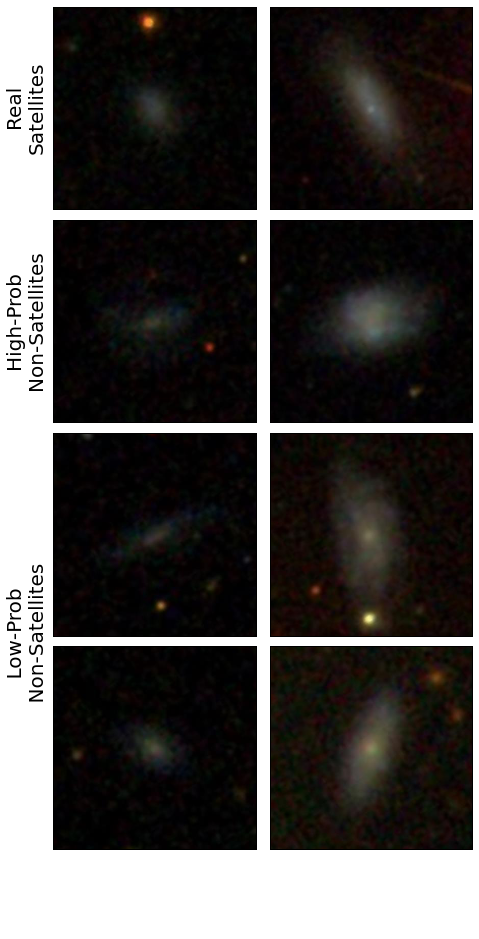

In [295]:
fig, spls = plt.subplots(4, 2, figsize=(7, 12))

for ax, row in zip(spls[0], realsats_rows):
    imdata = row_to_cutout_img(row)
    ax.imshow(imdata)
    ax.set_xticks([])
    ax.set_yticks([])

    
for ax, row in zip(spls[1], highprob_rows):
    imdata = row_to_cutout_img(row)
    ax.imshow(imdata)
    ax.set_xticks([])
    ax.set_yticks([])
    
for imcol in [0, 1]:
    for ax, row in zip(spls[2:, imcol], lowprob_rows[imcol]):
        imdata = row_to_cutout_img(row)
        ax.imshow(imdata)
        ax.set_xticks([])
        ax.set_yticks([])
        
spls[0, 0].set_ylabel('Real\nSatellites', fontsize=20)
spls[1, 0].set_ylabel('High-Prob\nNon-Satellites', fontsize=20)
fig.tight_layout()
spls[3, 0].set_ylabel('{0}Low-Prob\n{0}Non-Satellites'.format(' '*36), fontsize=20)
plt.savefig('satnonsatcomp.png')
plt.savefig('satnonsatcomp.pdf')